# Impact of Covid on the Housing Market

Data Sources:

- RAW_us_confirmed_cases.csv -- covid cases date range (02/02/2020 - 10/01/2021)
- Redfin housing market data

In [1]:
# Importing the required libraries

import pandas as pd
import numpy as np
import json
import requests
import math
import os
import warnings
import matplotlib.pyplot as plt  
import datetime as dt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
warnings.filterwarnings('ignore')

## Step 1: Data Acquisition

In [2]:
county_name = 'Shelby'
state_name = 'Tennessee'
state_name_abb = 'TN'
county_fips_code = 47157
county_population = 924454

In [3]:
# Covid Analysis Dates as mentioned in the Part 1 Analysis Plan

analysis_start_period = '2020-02-01'
analysis_end_period = '2021-10-01'

In [4]:
raw_data_path = './raw_data'
processed_data_path = './processed_data'

## Covid Data

In [5]:
raw_covid_data = pd.read_csv(os.path.join(raw_data_path, 'RAW_us_confirmed_cases.csv'))

In [6]:
raw_covid_data.head()

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22,10/31/22,11/1/22,11/2/22,11/3/22,11/4/22
0,Alabama,Autauga,84001001,US,USA,840,1001.0,US,32.539527,-86.644082,...,18480,18511,18511,18511,18511,18511,18511,18511,18511,18511
1,Alabama,Baldwin,84001003,US,USA,840,1003.0,US,30.727750,-87.722071,...,65895,65973,65973,65973,65973,65973,65973,65973,65973,65973
2,Alabama,Barbour,84001005,US,USA,840,1005.0,US,31.868263,-85.387129,...,6926,6930,6930,6930,6930,6930,6930,6930,6930,6930
3,Alabama,Bibb,84001007,US,USA,840,1007.0,US,32.996421,-87.125115,...,7560,7575,7575,7575,7575,7575,7575,7575,7575,7575
4,Alabama,Blount,84001009,US,USA,840,1009.0,US,33.982109,-86.567906,...,17286,17320,17320,17320,17320,17320,17320,17320,17320,17320


Here the attribute 'Admin2' corresponds to County and since we are doing the analysis based on the assigned counties, we will filter this data for our county. However, since 'Shelby' as a county exists for 9 states, we filter on the specific state as well.

In [7]:
raw_covid_data = raw_covid_data[(raw_covid_data['Admin2'] == 'Shelby') \
                                & (raw_covid_data['Province_State'] == 'Tennessee')]

In [8]:
raw_covid_data

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22,10/31/22,11/1/22,11/2/22,11/3/22,11/4/22
2682,Tennessee,Shelby,84047157,US,USA,840,47157.0,US,35.186478,-89.896924,...,275944,276073,276169,276199,276199,276199,276199,276199,276199,276199


We now need to unpivot this data. We will do so using melt() to unpivot this time series data from wide format to long format.

In [9]:
covid_confirmed_cases = pd.melt(raw_covid_data, id_vars= raw_covid_data.columns[1:11] \
                                , value_vars = raw_covid_data.columns[11:], var_name= 'Date_series', value_name= 'Cumulative_cases')


In [10]:
covid_confirmed_cases

,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,Combined_Key,Date_series,Cumulative_cases
0,Shelby,84047157,US,USA,840,47157.0,US,35.186478,-89.896924,"Shelby, Tennessee, US",1/22/20,0
1,Shelby,84047157,US,USA,840,47157.0,US,35.186478,-89.896924,"Shelby, Tennessee, US",1/23/20,0
2,Shelby,84047157,US,USA,840,47157.0,US,35.186478,-89.896924,"Shelby, Tennessee, US",1/24/20,0
3,Shelby,84047157,US,USA,840,47157.0,US,35.186478,-89.896924,"Shelby, Tennessee, US",1/25/20,0
4,Shelby,84047157,US,USA,840,47157.0,US,35.186478,-89.896924,"Shelby, Tennessee, US",1/26/20,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1013,Shelby,84047157,US,USA,840,47157.0,US,35.186478,-89.896924,"Shelby, Tennessee, US",10/31/22,276199
1014,Shelby,84047157,US,USA,840,47157.0,US,35.186478,-89.896924,"Shelby, Tennessee, US",11/1/22,276199
1015,Shelby,84047157,US,USA,840,47157.0,US,35.186478,-89.896924,"Shelby, Tennessee, US",11/2/22,276199
1016,Shelby,84047157,US,USA,840,47157.0,US,35.186478,-89.896924,"Shelby, Tennessee, US",11/3/22,276199


Now we will filter for the date range of our covid analysis.

In [11]:
# Converting the date column to the relevant data type
covid_confirmed_cases['Date_series'] = pd.to_datetime(covid_confirmed_cases['Date_series'])

# Filtering the df from February 2020 to October 2021

covid_confirmed_cases = covid_confirmed_cases[(covid_confirmed_cases['Date_series'] >= analysis_start_period) \
                                               & (covid_confirmed_cases['Date_series'] <= analysis_end_period)]

# Sorting
#covid_confirmed_cases.sort_values(['Date_series'], ascending= True)


# Filtering for the columns that we would be using for our analysis
# We just need the time series so we will be filtering out all the other columns

covid_confirmed_cases = covid_confirmed_cases[['Date_series', 'Cumulative_cases']]

# The cases in our given time series are accumulated and do not show the daily cases.
# We use diff() to calculate the actual daily cases.
covid_confirmed_cases['Daily_cases'] = covid_confirmed_cases['Cumulative_cases'].diff()
covid_confirmed_cases['Daily_cases'] = covid_confirmed_cases['Daily_cases'].fillna(0)
covid_confirmed_cases = covid_confirmed_cases.astype({"Daily_cases":"int"})

In [12]:
covid_confirmed_cases = covid_confirmed_cases[['Date_series', 'Daily_cases']]

In [13]:
covid_confirmed_cases.head()

,Date_series,Daily_cases
10,2020-02-01,0
11,2020-02-02,0
12,2020-02-03,0
13,2020-02-04,0
14,2020-02-05,0


In [14]:
covid_confirmed_cases.tail()

,Date_series,Daily_cases
614,2021-09-27,255
615,2021-09-28,272
616,2021-09-29,346
617,2021-09-30,286
618,2021-10-01,297


Now we will be adding new columns to do our analysis. We will be calculating a 7-day moving mooving average which means it would take covid cases of the past 7 days, adds them up and divides by 7. 7-day moving average is really useful and important in terms of covid-cases  because it can provide an average line over time and knock out any big peak or valleys to the average over a period of time.

Plus, since we are looking at weekly housing data, this would complement that analysis and help us to do the weekly analysis 

In [15]:
covid_confirmed_cases['Moving_avg_cases'] = covid_confirmed_cases.Daily_cases.rolling(window = 7).mean().round()

In [16]:
covid_confirmed_cases.head()

,Date_series,Daily_cases,Moving_avg_cases
10,2020-02-01,0,NaN
11,2020-02-02,0,NaN
12,2020-02-03,0,NaN
13,2020-02-04,0,NaN
14,2020-02-05,0,NaN


In [17]:
covid_confirmed_cases['Moving_avg_cases'] = covid_confirmed_cases['Moving_avg_cases'].fillna(0)
covid_confirmed_cases = covid_confirmed_cases.astype({'Moving_avg_cases' : 'int'})
covid_confirmed_cases = covid_confirmed_cases[['Date_series', 'Daily_cases', 'Moving_avg_cases']]

In [18]:
covid_confirmed_cases.head()

,Date_series,Daily_cases,Moving_avg_cases
10,2020-02-01,0,0
11,2020-02-02,0,0
12,2020-02-03,0,0
13,2020-02-04,0,0
14,2020-02-05,0,0


We will now convert this into weekly data. We will use pd.resample() method for frequency conversion and resampling of time series.
Syntax:
<DataFrame or Series>.resample(arguments).<aggregate function>
Reference: https://towardsdatascience.com/using-the-pandas-resample-function-a231144194c4

In [19]:
# Downscaling the data using resample() into weekly periods
covid_confirmed_cases_weekly = covid_confirmed_cases.resample("W", on = 'Date_series').sum().reset_index()
# Renaming the date column
covid_confirmed_cases_weekly.rename(columns= {'Date_series': 'Week_end'}, inplace=True)

# Creating week begin columns
covid_confirmed_cases_weekly['Week_begin'] = covid_confirmed_cases_weekly['Week_end'] - pd.DateOffset(days = 6)

# Arranging the order of columns in the dataframe
covid_confirmed_cases_weekly = covid_confirmed_cases_weekly[['Week_begin', 'Week_end', 'Daily_cases', 'Moving_avg_cases']]


In [20]:
covid_confirmed_cases_weekly.head()

,Week_begin,Week_end,Daily_cases,Moving_avg_cases
0,2020-01-27,2020-02-02,0,0
1,2020-02-03,2020-02-09,0,0
2,2020-02-10,2020-02-16,0,0
3,2020-02-17,2020-02-23,0,0
4,2020-02-24,2020-03-01,0,0


In [21]:
covid_confirmed_cases_weekly['Cumulative_cases'] = covid_confirmed_cases_weekly['Daily_cases'].cumsum()

In [22]:
covid_confirmed_cases_weekly.head(10)

,Week_begin,Week_end,Daily_cases,Moving_avg_cases,Cumulative_cases
0,2020-01-27,2020-02-02,0,0,0
1,2020-02-03,2020-02-09,0,0,0
2,2020-02-10,2020-02-16,0,0,0
3,2020-02-17,2020-02-23,0,0,0
4,2020-02-24,2020-03-01,0,0,0
5,2020-03-02,2020-03-08,1,0,1
6,2020-03-09,2020-03-15,1,0,2
7,2020-03-16,2020-03-22,64,16,66
8,2020-03-23,2020-03-29,296,189,362
9,2020-03-30,2020-04-05,441,416,803


In [23]:
covid_confirmed_cases_weekly.tail(10)

,Week_begin,Week_end,Daily_cases,Moving_avg_cases,Cumulative_cases
78,2021-07-26,2021-08-01,3007,2437,105607
79,2021-08-02,2021-08-08,3973,3592,109580
80,2021-08-09,2021-08-15,4447,4183,114027
81,2021-08-16,2021-08-22,5452,4915,119479
82,2021-08-23,2021-08-29,4351,4817,123830
83,2021-08-30,2021-09-05,4747,4827,128577
84,2021-09-06,2021-09-12,5473,5312,134050
85,2021-09-13,2021-09-19,2956,3959,137006
86,2021-09-20,2021-09-26,2305,2588,139311
87,2021-09-27,2021-10-03,1456,1457,140767


## Housing Market Data

### Part A: Weekly Housing Market Data

In [24]:
raw_housing_data = pd.read_csv('weekly_housing_market_data_most_recent.tsv000', sep= '\t')

In [25]:
raw_housing_data.head()

,region_id,region_type_id,region_name,region_type,period_begin,period_end,duration,total_homes_sold,total_homes_sold_yoy,average_homes_sold,...,average_adjustment_average_homes_sold,adjusted_average_homes_sold,average_adjustment_average_new_listings,adjusted_average_new_listings,average_adjustment_pending_sales,adjusted_pending_sales,adjusted_average_homes_delisted_yoy,adjusted_average_homes_sold_yoy,adjusted_average_new_listings_yoy,adjusted_pending_sales_yoy
0,1548,5,"Jasper County, MS",county,2017-06-05,2017-06-11,1 weeks,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1548,5,"Jasper County, MS",county,2017-03-20,2017-06-11,12 weeks,1.0,NaN,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1548,5,"Jasper County, MS",county,2017-05-15,2017-06-11,4 weeks,1.0,NaN,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1913,5,"Catron County, NM",county,2017-06-05,2017-06-11,1 weeks,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1913,5,"Catron County, NM",county,2017-03-20,2017-06-11,12 weeks,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN


### Cleaning and Data Processing of the **Weekly** Housing Market Data

Here I will perform data processing to filter data for Shelby County and Tennessee state. I will filter the data from Februaury 2020 to October 2021.

In [26]:
redfin_housing_data = raw_housing_data[(raw_housing_data["region_name"].str.contains("Shelby County, TN")) \
                                       & (raw_housing_data["duration"] == '1 weeks')]

In [27]:
redfin_housing_data.head()

,region_id,region_type_id,region_name,region_type,period_begin,period_end,duration,total_homes_sold,total_homes_sold_yoy,average_homes_sold,...,average_adjustment_average_homes_sold,adjusted_average_homes_sold,average_adjustment_average_new_listings,adjusted_average_new_listings,average_adjustment_pending_sales,adjusted_pending_sales,adjusted_average_homes_delisted_yoy,adjusted_average_homes_sold_yoy,adjusted_average_new_listings_yoy,adjusted_pending_sales_yoy
382385,2623,5,"Shelby County, TN",county,2017-01-23,2017-01-29,1 weeks,193.0,-0.134529,193.0,...,NaN,193.0,NaN,279.0,NaN,119.0,-0.298507,-0.134529,0.056818,-0.105263
385420,2623,5,"Shelby County, TN",county,2017-01-16,2017-01-22,1 weeks,139.0,0.139344,139.0,...,NaN,139.0,NaN,242.0,NaN,115.0,-0.125000,0.139344,0.163462,0.292135
386089,2623,5,"Shelby County, TN",county,2017-01-30,2017-02-05,1 weeks,222.0,0.776000,222.0,...,NaN,222.0,NaN,277.0,NaN,128.0,0.085106,0.776000,-0.064189,0.207547
389947,2623,5,"Shelby County, TN",county,2017-02-06,2017-02-12,1 weeks,100.0,-0.236641,100.0,...,NaN,100.0,NaN,249.0,NaN,113.0,0.276596,-0.236641,-0.034884,0.008929
416813,2623,5,"Shelby County, TN",county,2017-01-09,2017-01-15,1 weeks,201.0,0.348993,201.0,...,NaN,201.0,NaN,212.0,NaN,128.0,-0.281250,0.348993,-0.097872,0.333333


In [28]:
# Converting date columns to relevant data type

redfin_housing_data['period_begin'] = pd.to_datetime(redfin_housing_data['period_begin'])
redfin_housing_data['period_end'] = pd.to_datetime(redfin_housing_data['period_end'])

# Filtering these as per our analysis timeline for covid which is from February 2020 to October 2021

redfin_housing_data = redfin_housing_data[(redfin_housing_data['period_begin'] >= analysis_start_period) \
                                          & (redfin_housing_data['period_end'] <= analysis_end_period)]

# Sorting by the periods
redfin_housing_data = redfin_housing_data.sort_values(['period_begin', 'period_end'], ascending = (True, True))

redfin_housing_data.rename(columns = {'period_begin': 'Week_begin', 'period_end': 'Week_end'}, inplace= True)

# Now we will filter for the columns that we want
redfin_housing_data = redfin_housing_data[['Week_begin', 'Week_end', 'inventory', 'total_homes_sold'\
                                          , 'median_sale_price', 'median_new_listing_price', 'total_new_listings']]


In [29]:
redfin_housing_data

,Week_begin,Week_end,inventory,total_homes_sold,median_sale_price,median_new_listing_price,total_new_listings
2356283,2020-02-03,2020-02-09,2162.0,146.0,148000.0,185000.0,261.0
2258866,2020-02-10,2020-02-16,2147.0,183.0,170000.0,213750.0,230.0
2305542,2020-02-17,2020-02-23,2166.0,170.0,180000.0,181500.0,214.0
2265123,2020-02-24,2020-03-01,2097.0,281.0,199999.0,185000.0,257.0
2247570,2020-03-02,2020-03-08,2131.0,194.0,202400.0,225000.0,264.0
...,...,...,...,...,...,...,...
2826811,2021-08-23,2021-08-29,1950.0,280.0,236000.0,210000.0,317.0
2835877,2021-08-30,2021-09-05,1890.0,357.0,251000.0,227450.0,287.0
2835973,2021-09-06,2021-09-12,1883.0,227.0,230000.0,249900.0,261.0
2868062,2021-09-13,2021-09-19,1856.0,254.0,250000.0,218750.0,276.0


## Step 3: Data Analysis

Now we will combine both the weekly redfin housing data with the weekly covid data that we created above. We will perform an outer merge on them on the Week_begin and Week_end columns.

In [30]:
covid_housing_combined = pd.merge(covid_confirmed_cases_weekly, redfin_housing_data, on= ['Week_begin', 'Week_end'],how= 'outer')

In [31]:
covid_housing_combined.head()

,Week_begin,Week_end,Daily_cases,Moving_avg_cases,Cumulative_cases,inventory,total_homes_sold,median_sale_price,median_new_listing_price,total_new_listings
0,2020-01-27,2020-02-02,0,0,0,NaN,NaN,NaN,NaN,NaN
1,2020-02-03,2020-02-09,0,0,0,2162.0,146.0,148000.0,185000.0,261.0
2,2020-02-10,2020-02-16,0,0,0,2147.0,183.0,170000.0,213750.0,230.0
3,2020-02-17,2020-02-23,0,0,0,2166.0,170.0,180000.0,181500.0,214.0
4,2020-02-24,2020-03-01,0,0,0,2097.0,281.0,199999.0,185000.0,257.0


In [71]:
# saving this dataset
covid_housing_combined.to_csv('./preprocessed_data/weekly_covid_housing_combined_data.csv')

## Step 4: Visualization

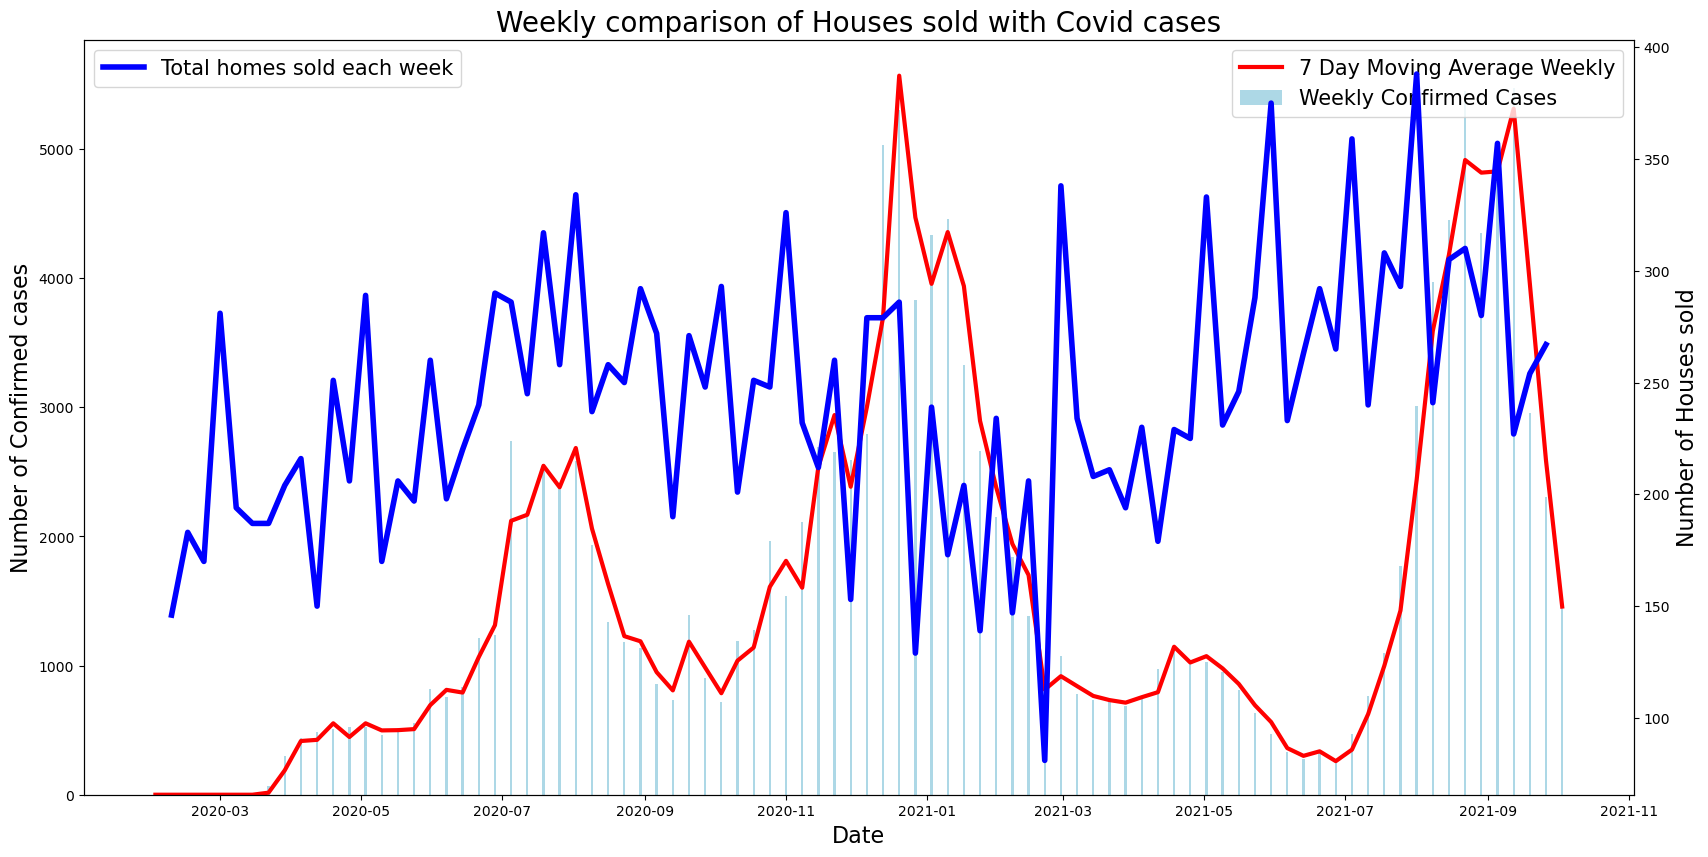

In [65]:
figure(figsize = (20,10), dpi = 100)
#plt.grid(True)
ax = plt.gca()
ax2 = plt.twinx()

# Confirmed cases
ax.bar(covid_housing_combined['Week_end'], covid_housing_combined['Daily_cases'] \
       , color='lightblue', label='Weekly Confirmed Cases', width=1)

# Plotting the 7-day moving average to see the actual trend
ax.plot(covid_housing_combined['Week_end'], covid_housing_combined['Moving_avg_cases'], color='red', label='7 Day Moving Average Weekly', linewidth=3)


# Plotting homes sold
ax2.plot(covid_housing_combined['Week_end'], covid_housing_combined['total_homes_sold'], \
         color='blue', label='Total homes sold each week', linewidth=4)

ax.set_xlabel('Date', fontsize = 16)
plt.title('Weekly comparison of Houses sold with Covid cases', fontsize = 20)

ax.set_ylabel('Number of Confirmed cases', fontsize = 16)
ax2.set_ylabel('Number of Houses sold', fontsize = 16)

ax.legend(loc = 1, fontsize = 15)
ax2.legend(loc = 2, fontsize = 15)

plt.savefig('./visualizations/weekly_comparisons/weekly_covid_vs_houses_sold.jpeg')



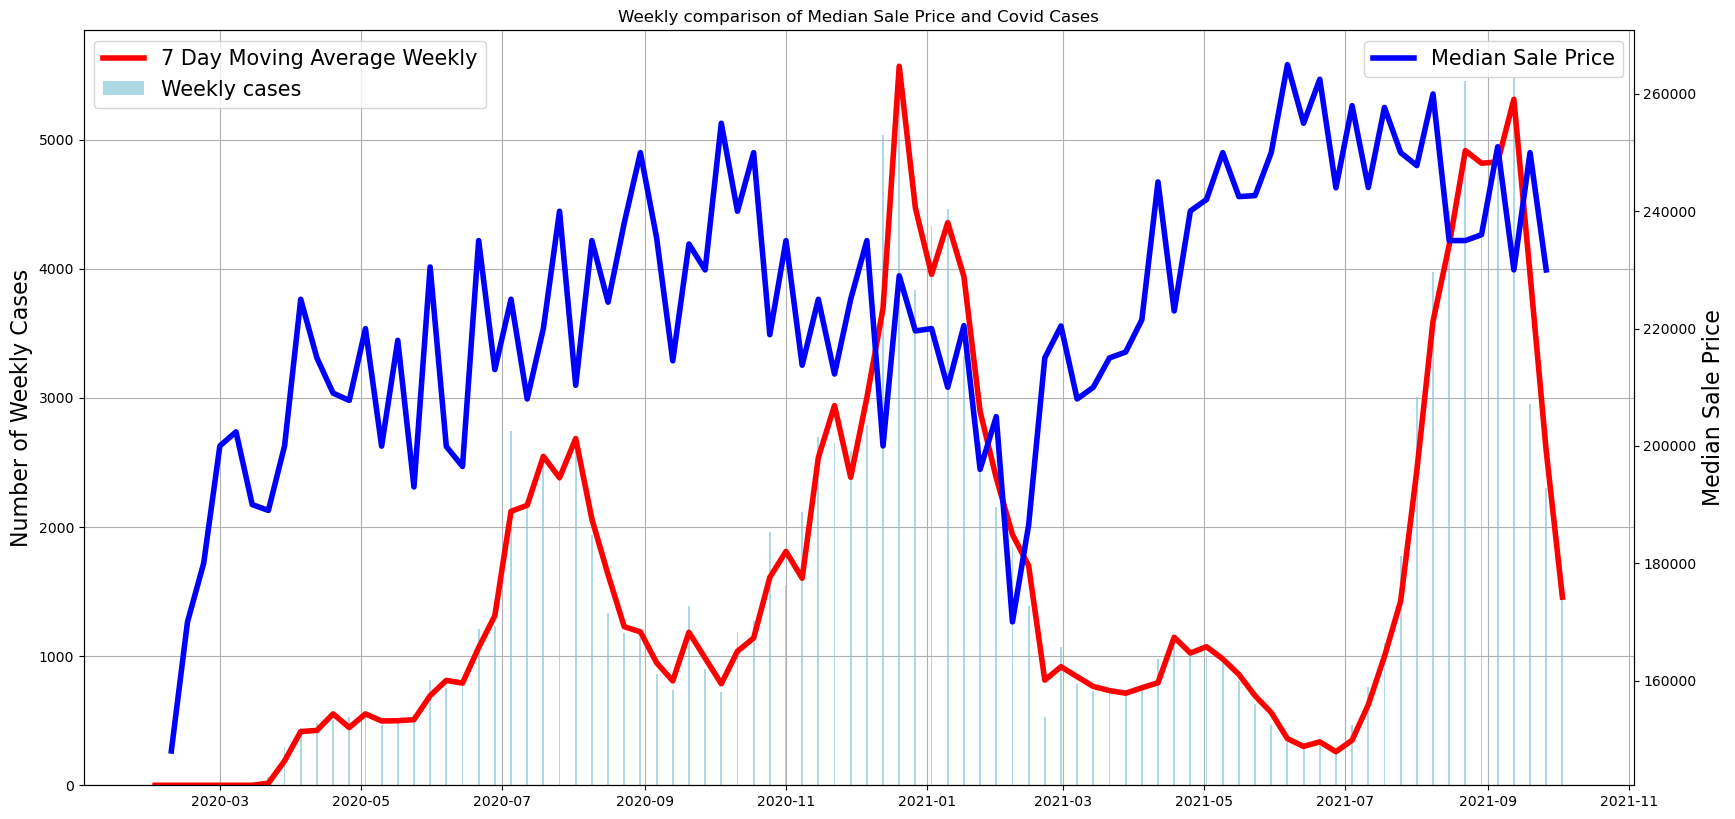

In [33]:
# Visualization 2: Comparing Weekly covid cases with the Median Sales prices of the houses

figure(figsize=(20,10), dpi=100)
plt.grid(True)

ax = plt.gca()
ax2 = plt.twinx()

# Covid cases
ax.bar(covid_housing_combined['Week_end'], covid_housing_combined['Daily_cases'], color = 'lightblue', label = 'Weekly cases', linewidth=1)

# 7-day moving average
ax.plot(covid_housing_combined['Week_end'], covid_housing_combined['Moving_avg_cases'], color = 'red', label = '7 Day Moving Average Weekly', linewidth = 4)

# Adding median sale price
ax2.plot(covid_housing_combined['Week_end'], covid_housing_combined['median_sale_price'], color = 'blue', label = 'Median Sale Price', linewidth = 4)


plt.xlabel('Date', fontsize =16)
plt.title('Weekly comparison of Median Sale Price and Covid Cases')

ax.set_ylabel('Number of Weekly Cases', fontsize = 16)
ax2.set_ylabel('Median Sale Price', fontsize = 16)

ax.legend(loc = 2, fontsize = 15)
ax2.legend(loc = 1, fontsize = 15)

plt.savefig('./visualizations/weekly_comparisons/weekly_covid_vs_median_SP.jpeg')



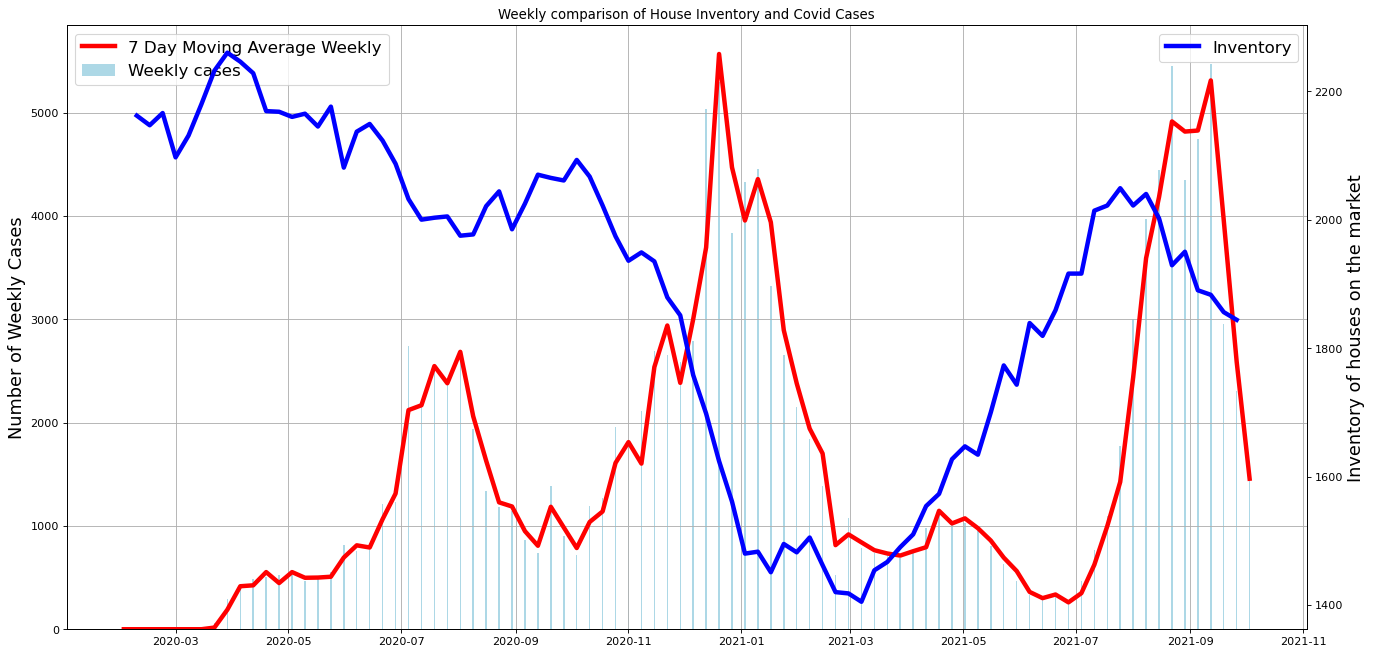

In [34]:
# Visualization 3: Comparing Weekly covid cases with the Inventory of the houses

figure(figsize=(20,10), dpi=80)
plt.grid(True)

ax = plt.gca()
ax2 = plt.twinx()

# Covid cases
ax.bar(covid_housing_combined['Week_end'], covid_housing_combined['Daily_cases'], color = 'lightblue', label = 'Weekly cases', linewidth=1)

# 7-day moving average
ax.plot(covid_housing_combined['Week_end'], covid_housing_combined['Moving_avg_cases'], color = 'red', label = '7 Day Moving Average Weekly', linewidth = 4)

# Adding median sale price
ax2.plot(covid_housing_combined['Week_end'], covid_housing_combined['inventory'], color = 'blue', label = 'Inventory', linewidth = 4)


plt.xlabel('Date', fontsize =16)
plt.title('Weekly comparison of House Inventory and Covid Cases')

ax.set_ylabel('Number of Weekly Cases', fontsize = 16)
ax2.set_ylabel('Inventory of houses on the market', fontsize = 16)

ax.legend(loc = 2, fontsize = 15)
ax2.legend(loc = 1, fontsize = 15)

plt.savefig('./visualizations/weekly_comparisons/weekly_covid_vs_houses_Inventory.jpeg')



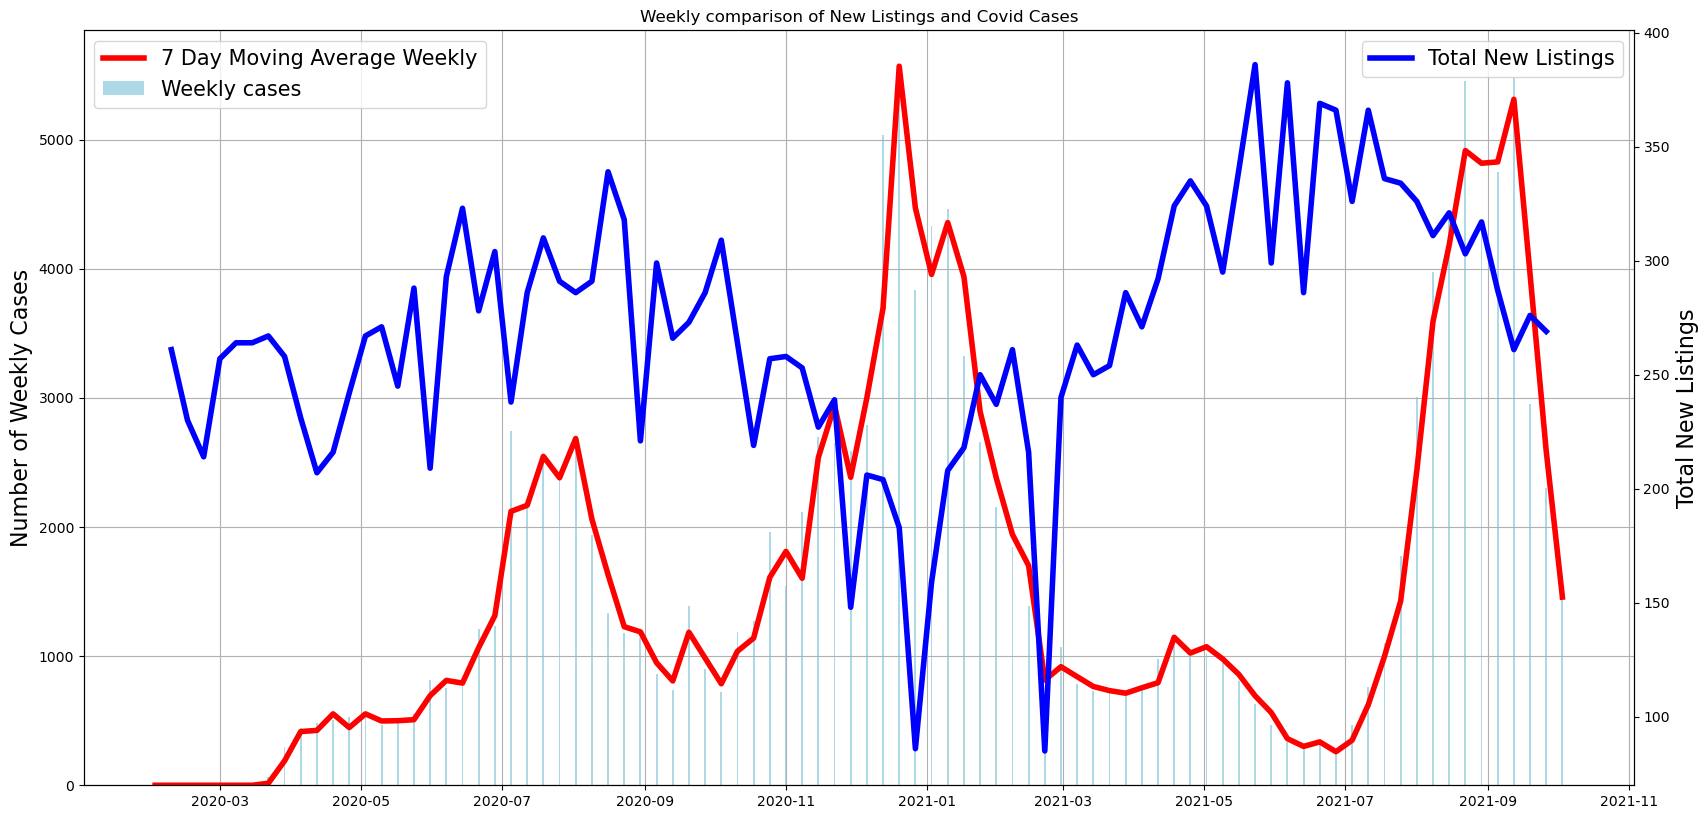

In [35]:
# Visualization 4: Comparing Weekly covid cases with the New Listings of SFH

figure(figsize=(20,10), dpi=100)
plt.grid(True)

ax = plt.gca()
ax2 = plt.twinx()

# Covid cases
ax.bar(covid_housing_combined['Week_end'], covid_housing_combined['Daily_cases'], color = 'lightblue', label = 'Weekly cases', linewidth=1)

# 7-day moving average
ax.plot(covid_housing_combined['Week_end'], covid_housing_combined['Moving_avg_cases'], color = 'red', label = '7 Day Moving Average Weekly', linewidth = 4)

# Adding median sale price
ax2.plot(covid_housing_combined['Week_end'], covid_housing_combined['total_new_listings'], color = 'blue', label = 'Total New Listings', linewidth = 4)


plt.xlabel('Date', fontsize =16)
plt.title('Weekly comparison of New Listings and Covid Cases')

ax.set_ylabel('Number of Weekly Cases', fontsize = 16)
ax2.set_ylabel('Total New Listings', fontsize = 16)

ax.legend(loc = 2, fontsize = 15)
ax2.legend(loc = 1, fontsize = 15)

plt.savefig('./visualizations/weekly_comparisons/weekly_covid_vs_new_listings.jpeg')



In [36]:
mortgage_interest_rate = pd.read_csv(os.path.join(raw_data_path, 'MORTGAGE30US.csv'))

In [37]:
mortgage_interest_rate.head()

,DATE,MORTGAGE30US
0,2020-02-06,3.45
1,2020-02-13,3.47
2,2020-02-20,3.49
3,2020-02-27,3.45
4,2020-03-05,3.29


In [38]:
# Filtering out for our analysis period

mortgage_interest_rate = mortgage_interest_rate[(mortgage_interest_rate['DATE'] >= analysis_start_period) \
                                               & (mortgage_interest_rate['DATE'] <= analysis_end_period)]

mortgage_interest_rate['DATE'] = pd.to_datetime(mortgage_interest_rate['DATE'])

In [39]:
mortgage_interest_rate.head()

,DATE,MORTGAGE30US
0,2020-02-06,3.45
1,2020-02-13,3.47
2,2020-02-20,3.49
3,2020-02-27,3.45
4,2020-03-05,3.29


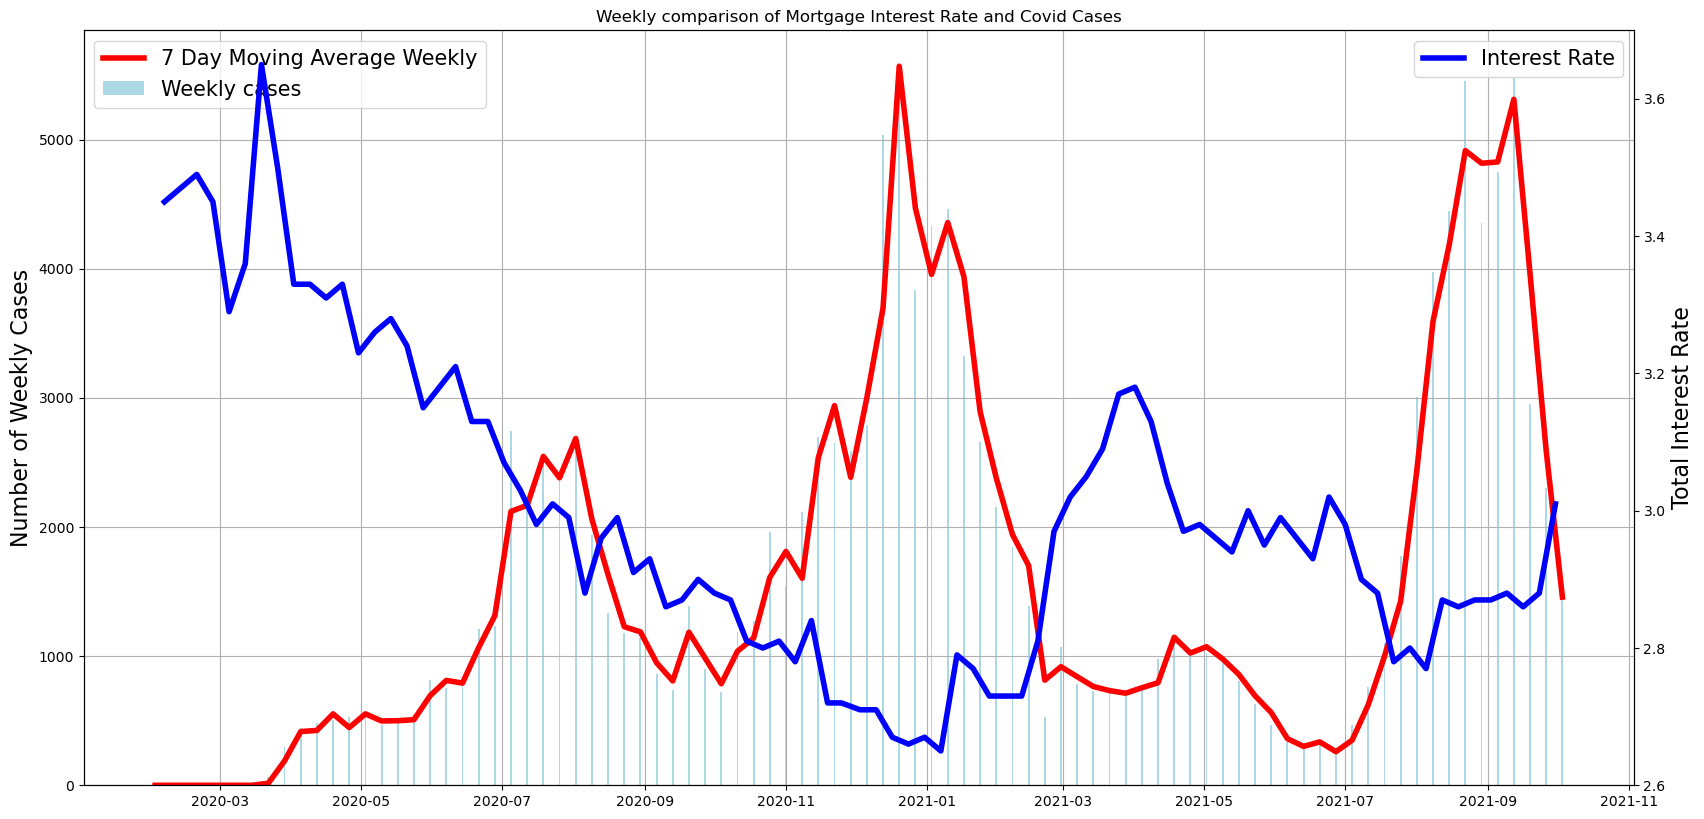

In [69]:
# Visualization 5: Comparing Weekly covid cases with the Mortgage Interest Rates

figure(figsize=(20,10), dpi=100)
plt.grid(True)

ax = plt.gca()
ax2 = plt.twinx()

# Covid cases
ax.bar(covid_housing_combined['Week_end'], covid_housing_combined['Daily_cases'], color = 'lightblue', label = 'Weekly cases', linewidth=1)

# 7-day moving average
ax.plot(covid_housing_combined['Week_end'], covid_housing_combined['Moving_avg_cases'], color = 'red', label = '7 Day Moving Average Weekly', linewidth = 4)

# Adding median sale price
ax2.plot(mortgage_interest_rate['DATE'], mortgage_interest_rate['MORTGAGE30US'], color = 'blue', label = 'Interest Rate', linewidth = 4)


plt.xlabel('Date', fontsize =16)
plt.title('Weekly comparison of Mortgage Interest Rate and Covid Cases')

ax.set_ylabel('Number of Weekly Cases', fontsize = 16)
ax2.set_ylabel('Total Interest Rate', fontsize = 16)

ax.legend(loc = 2, fontsize = 15)
ax2.legend(loc = 1, fontsize = 15)

plt.savefig('./visualizations/Weekly_comparisons/weekly_covid_vs_interest_rates.jpeg')


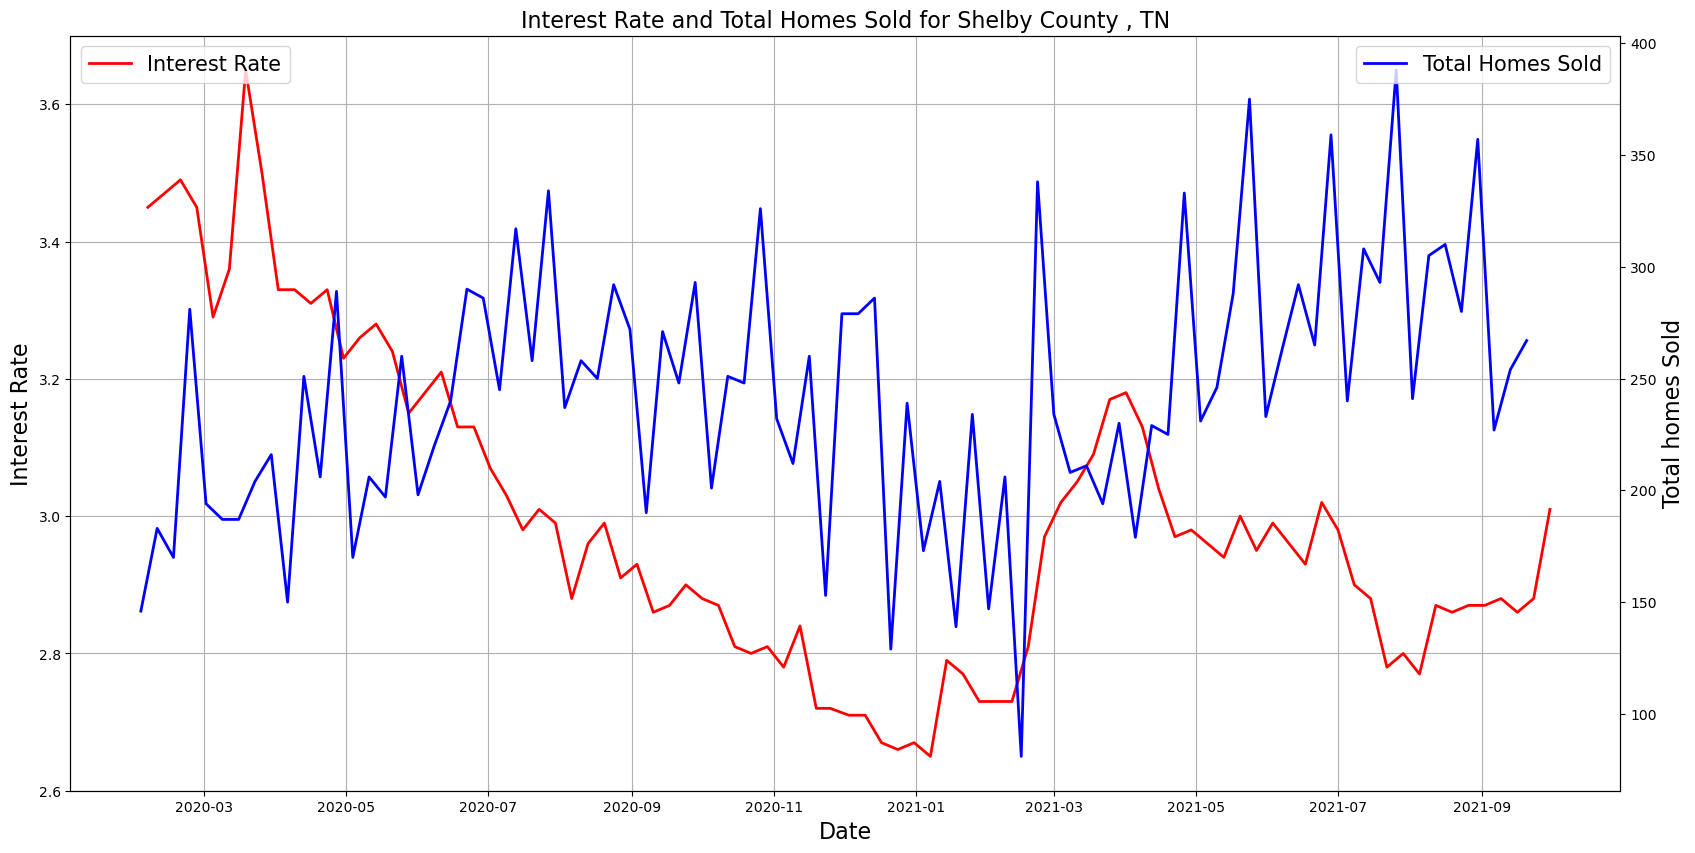

In [68]:
# Visualization showing Houses Sold and 30-year Mortgagae Interest Rates during Covid-19

figure(figsize=(20, 10), dpi=100)
plt.grid(True)

ax = plt.gca()
ax2 = plt.twinx()

ax.plot(mortgage_interest_rate['DATE'], mortgage_interest_rate['MORTGAGE30US'], color = 'red', label = 'Interest Rate', linewidth = 2)
ax2.plot(covid_housing_combined['Week_begin'], covid_housing_combined['total_homes_sold'], color='blue', label='Total Homes Sold', linewidth=2)

ax.set_xlabel('Date', fontsize=16)
plt.title('Interest Rate and Total Homes Sold for Shelby County , TN', fontsize=16)

ax.set_ylabel('Interest Rate', fontsize=16)
ax2.set_ylabel('Total homes Sold', fontsize=16)

ax.legend(loc=2, fontsize=15)
ax2.legend(loc=1, fontsize=15)

plt.savefig('./visualizations/Weekly_comparisons/interest_rates_vs_homes_sold.jpeg')



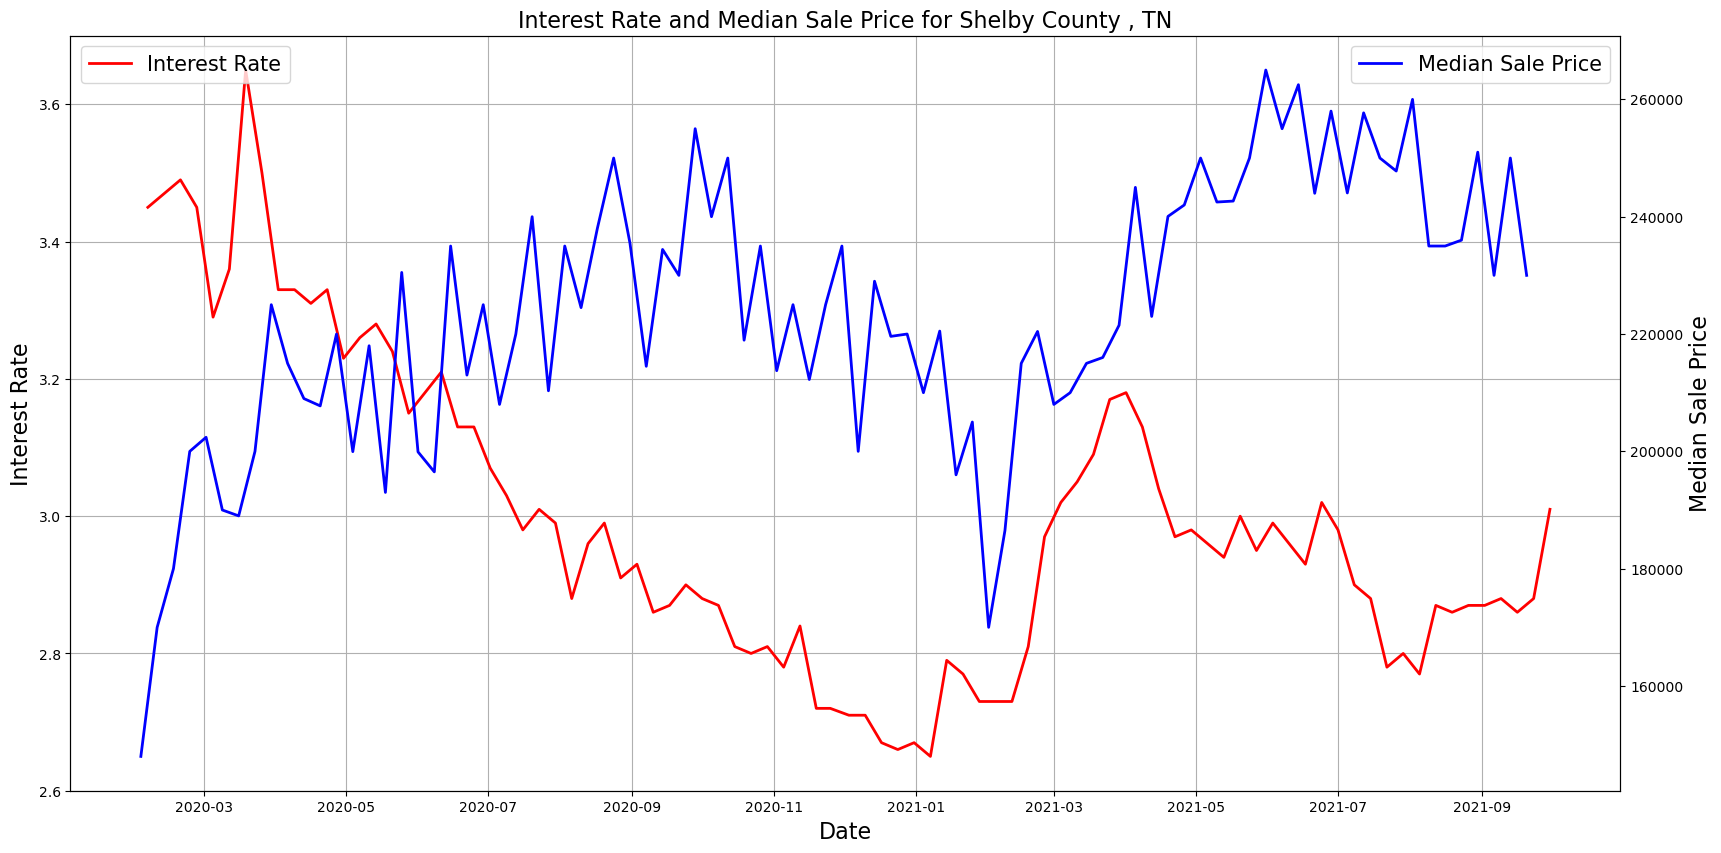

In [67]:
# Visualization showing Houses Sold and 30-year Mortgagae Interest Rates during Covid-19

figure(figsize=(20, 10), dpi=100)
plt.grid(True)

ax = plt.gca()
ax2 = plt.twinx()

ax.plot(mortgage_interest_rate['DATE'], mortgage_interest_rate['MORTGAGE30US'], color = 'red', label = 'Interest Rate', linewidth = 2)
ax2.plot(covid_housing_combined['Week_begin'], covid_housing_combined['median_sale_price'], color='blue', label='Median Sale Price', linewidth=2)

ax.set_xlabel('Date', fontsize=16)
plt.title('Interest Rate and Median Sale Price for Shelby County , TN', fontsize=16)

ax.set_ylabel('Interest Rate', fontsize=16)
ax2.set_ylabel('Median Sale Price', fontsize=16)

ax.legend(loc=2, fontsize=15)
ax2.legend(loc=1, fontsize=15)

plt.savefig('./visualizations/Weekly_comparisons/interest_rates_vs_median_SP.jpeg')


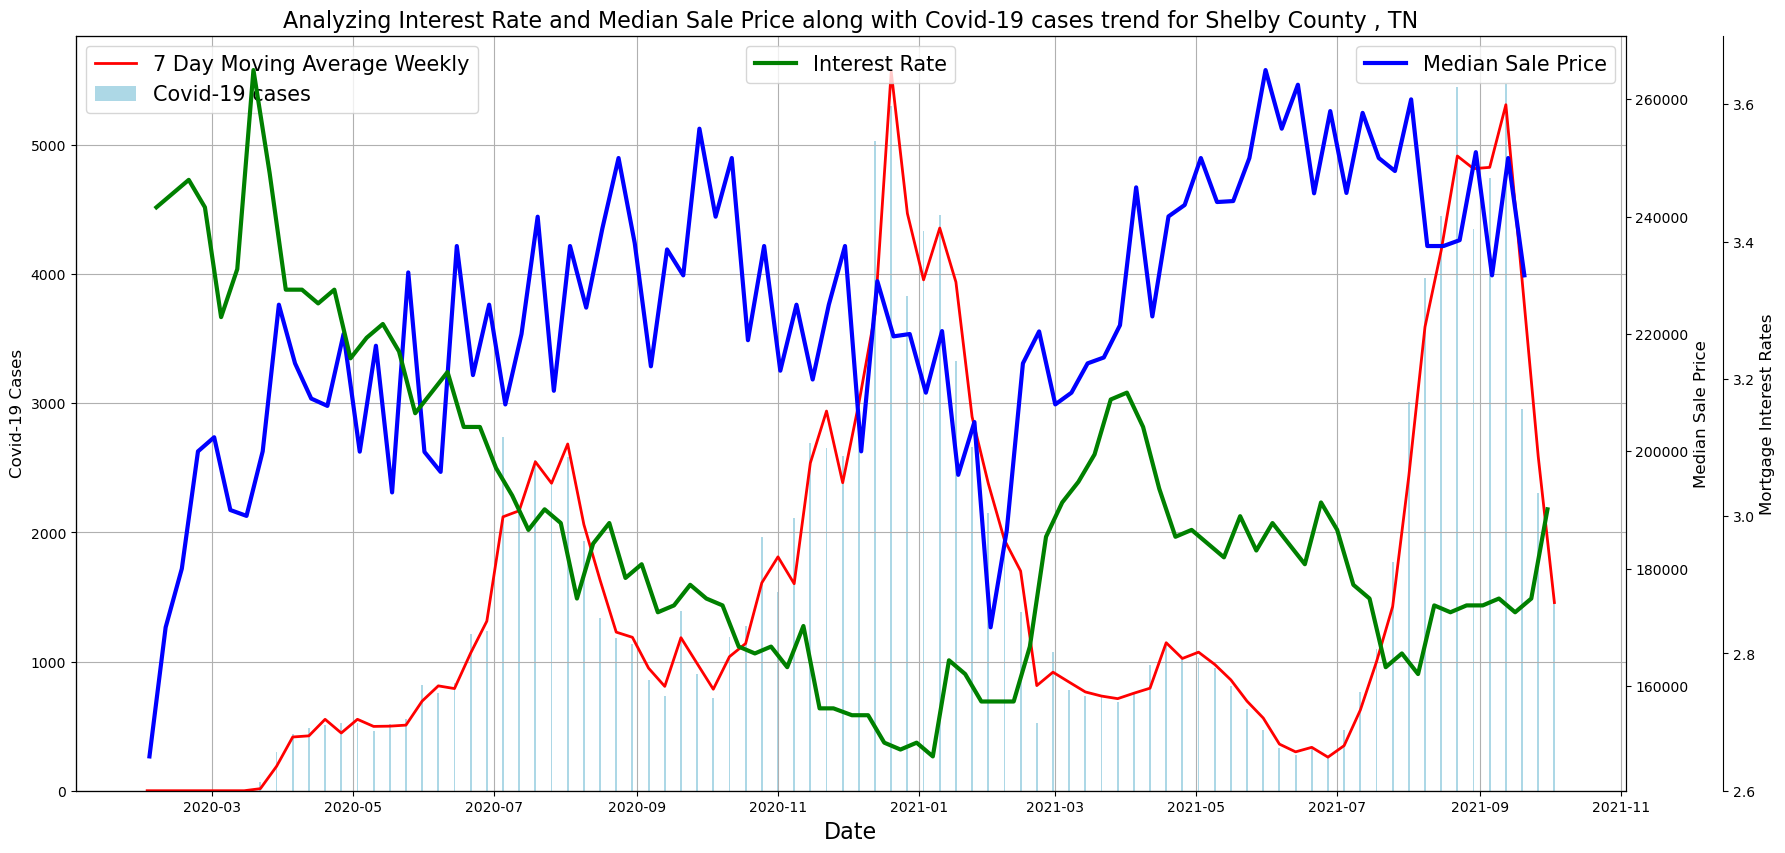

In [66]:
# Visualization showing Total Sales Price and 30-year Mortgagae Interest Rates during Covid-19

figure(figsize=(20, 10), dpi=100)
plt.grid(True)

ax = plt.gca()
ax2 = ax.twinx()
ax3 = ax.twinx()

# Covid cases
ax.bar(covid_housing_combined['Week_end'], covid_housing_combined['Daily_cases'], color = 'lightblue', label = 'Covid-19 cases', linewidth=1)
# 7-day moving average
ax.plot(covid_housing_combined['Week_end'], covid_housing_combined['Moving_avg_cases'], color = 'red', label = '7 Day Moving Average Weekly', linewidth = 2)

ax2.plot(covid_housing_combined['Week_begin'], covid_housing_combined['median_sale_price'], color='blue', label='Median Sale Price', linewidth=3)

ax3.plot(mortgage_interest_rate['DATE'], mortgage_interest_rate['MORTGAGE30US'], color = 'green', label = 'Interest Rate', linewidth = 3)
ax3.spines['right'].set_position(('outward', 70))

ax.set_xlabel('Date', fontsize=16)
plt.title('Analyzing Interest Rate and Median Sale Price along with Covid-19 cases trend for Shelby County , TN', fontsize=16)

ax.set_ylabel('Covid-19 Cases', fontsize=12)
ax2.set_ylabel('Median Sale Price', fontsize=12)
ax3.set_ylabel('Mortgage Interest Rates', fontsize=12)

ax.legend(loc= 'upper left', fontsize=15)
ax2.legend(loc= 'upper right', fontsize=15)
ax3.legend(loc = 'upper center', fontsize = 15)

plt.savefig('./visualizations/Weekly_comparisons/interest_rates_vs_homes_sold_vs_covid.jpeg')



## Linear Regression

In [73]:
# Importing the required libraries

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [74]:
redfin_housing_data_monthly = pd.read_csv(os.path.join(raw_data_path, 'TN_housing_data.csv'))

In [75]:
redfin_housing_data_monthly.head()

,Unnamed: 0,period_begin,period_end,period_duration,region_type,region_type_id,table_id,is_seasonally_adjusted,region,city,...,sold_above_list_yoy,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,parent_metro_region,parent_metro_region_metro_code,last_updated
0,13,2014-07-01,2014-07-31,30,county,5,2629,f,"Trousdale County, TN",NaN,...,-0.111111,NaN,NaN,NaN,0.0,NaN,-0.250000,"Nashville, TN",34980.0,2022-11-20 14:36:43
1,78,2012-02-01,2012-02-29,30,county,5,2545,f,"Anderson County, TN",NaN,...,-0.040143,NaN,NaN,NaN,0.0,0.0,-0.333333,"Knoxville, TN",28940.0,2022-11-20 14:36:43
2,107,2022-02-01,2022-02-28,30,county,5,2573,f,"Grainger County, TN",NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,"Morristown, TN",34100.0,2022-11-20 14:36:43
3,124,2019-01-01,2019-01-31,30,county,5,2605,f,"Meigs County, TN",NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,Tennessee nonmetropolitan area,NaN,2022-11-20 14:36:43
4,154,2022-10-01,2022-10-31,30,county,5,2627,f,"Sumner County, TN",NaN,...,0.000000,1.0,NaN,NaN,0.0,NaN,0.000000,"Nashville, TN",34980.0,2022-11-20 14:36:43


In [76]:
redfin_housing_data_monthly = redfin_housing_data_monthly[redfin_housing_data_monthly['region'].str.contains('Shelby County, TN')]

In [77]:
redfin_housing_data_monthly = redfin_housing_data_monthly[['period_begin', 'period_end', 'region', 'property_type', 'median_sale_price']]

In [78]:
redfin_housing_data_monthly = redfin_housing_data_monthly[redfin_housing_data_monthly['property_type'] == 'Single Family Residential']
redfin_housing_data_monthly['period_begin'] = pd.to_datetime(redfin_housing_data_monthly['period_begin'])
redfin_housing_data_monthly['period_end'] = pd.to_datetime(redfin_housing_data_monthly['period_end'])

redfin_housing_data_monthly = redfin_housing_data_monthly.sort_values(by = 'period_begin')


In [79]:
redfin_housing_data_monthly.head()

,period_begin,period_end,region,property_type,median_sale_price
4319,2012-01-01,2012-01-31,"Shelby County, TN",Single Family Residential,80000.0
1772,2012-02-01,2012-02-29,"Shelby County, TN",Single Family Residential,100000.0
1830,2012-03-01,2012-03-31,"Shelby County, TN",Single Family Residential,105000.0
4829,2012-04-01,2012-04-30,"Shelby County, TN",Single Family Residential,117000.0
12277,2012-05-01,2012-05-31,"Shelby County, TN",Single Family Residential,121000.0


In [80]:
housing_monthly_subset= redfin_housing_data_monthly[['period_begin', 'period_end', 'property_type', 'median_sale_price']].reset_index(drop = True)

In [81]:
housing_monthly_subset.head()

,period_begin,period_end,property_type,median_sale_price
0,2012-01-01,2012-01-31,Single Family Residential,80000.0
1,2012-02-01,2012-02-29,Single Family Residential,100000.0
2,2012-03-01,2012-03-31,Single Family Residential,105000.0
3,2012-04-01,2012-04-30,Single Family Residential,117000.0
4,2012-05-01,2012-05-31,Single Family Residential,121000.0


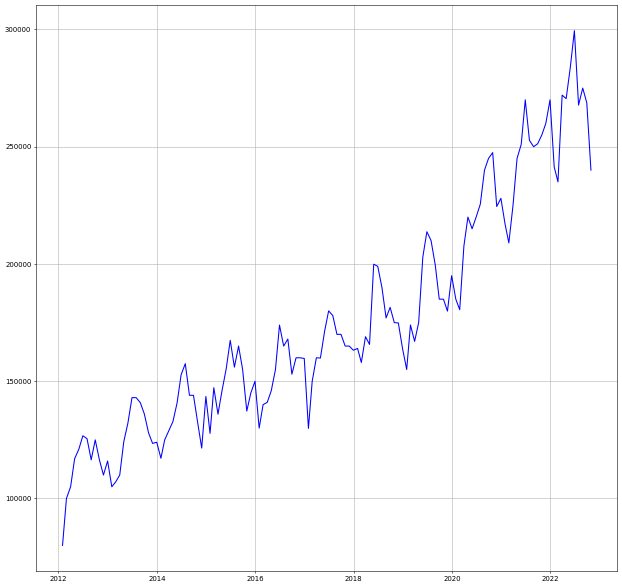

In [82]:
# Visualization: Looking at the overall median sale price trend

figure(figsize=(15,15), dpi= 50)
plt.grid()

ax = plt.gca()

ax.plot(housing_monthly_subset['period_end'],housing_monthly_subset['median_sale_price'], color = 'blue', label = 'Median Housing Sale Price Trend')
                               
                               
plt.savefig('./visualizations/LR/houses_SP_trend.jpeg')
                               
                               

We can clearly see that there is an overall increasing trend in the sale price of the housing market over the years. 

Now, since Linear regression does not work on date data, we need to convert it into numerical data and we do that through this method that converts objects of the datetime class and returns Gregorian ordinal of the date which is a numerical number.

In [83]:
housing_monthly_subset['ordinal_date'] = housing_monthly_subset['period_end'].map(dt.datetime.toordinal)

In [84]:
train_test_df = housing_monthly_subset[housing_monthly_subset['period_end'] < '2020-02-01']
validation_df = housing_monthly_subset[(housing_monthly_subset['period_end'] >= '2020-02-01') \
                                 & (housing_monthly_subset['period_end'] <= '2020-10-01')]

# We will split our data into 80:20
# First, we divide to our data into features X (independent variables)and label (y)(dependent varibale). 
# The dataframe gets divided into X_train, X_test, y_train and y_test.
# y_test sets that are used for training and fitting the model. 

X = train_test_df['ordinal_date'].values.reshape(-1,1)
y = train_test_df['median_sale_price']

# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=104,test_size=0.25, shuffle=True)


# Model

model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)
#print(model)
#print(y_pred)

print(f"Coefficient: {model.coef_}, Intercept:{model.intercept_}")
print(f"Model R-2 score: {model.score(X_train, y_train)}")

Coefficient: [26.3727299], Intercept:-19259437.489811506
Model R-2 score: 0.7737249363538624


In [85]:
def convert_ordinal_to_date(data):
    x = data.reshape(1,-1)
    ret_dates = []
    array_size = x.shape[1]
    for i in range(array_size):
        ret_dates.append(dt.datetime.fromordinal(x[0][i]).strftime("%Y-%m-%d"))
    
    return ret_dates

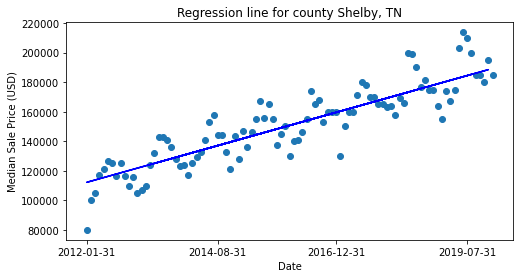

In [86]:
y_test_pred = model.predict(X_test)

fig2 = plt.figure(figsize=(8, 4))
ax = plt.axes()

ax.scatter(convert_ordinal_to_date(X), y)
ax.plot(convert_ordinal_to_date(X_test), y_test_pred, color='blue')

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y-%m')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_minor_locator(months)

ax.set_xlabel('Date')
ax.set_ylabel('Median Sale Price (USD)')
ax.axis('tight')
ax.set_title(f"Regression line for county Shelby, TN")

plt.savefig('./visualizations/LR/regression_line.jpeg')

In [87]:
print(f"The Actual Vs Predicted House Prices on Test Data for Shelby County, TN")

ml_df_test_set = pd.DataFrame({'date':convert_ordinal_to_date(X_test),'test_set_actual_prices': y_test, 'test_set_predicted_prices':  y_test_pred})
ml_df_test_set.set_index('date',inplace=True)
print(ml_df_test_set)
print("\n\n\n")

The Actual Vs Predicted House Prices on Test Data for Shelby County, TN
            test_set_actual_prices  test_set_predicted_prices
date                                                         
2018-05-31                199900.0              173176.676920
2013-11-30                123500.0              129846.281686
2013-09-30                136000.0              128237.545162
2015-12-31                150000.0              149915.929144
2019-12-31                195000.0              188446.487535
2017-12-31                163200.0              169194.394704
2014-04-30                132777.0              133828.563902
2016-07-31                165000.0              155533.320613
2013-04-30                124217.5              124202.517486
2013-12-31                124000.0              130663.836313
2014-12-31                143500.0              140289.882728
2012-01-31                 80000.0              112202.925380
2016-04-30                146000.0              153107.02946

In [88]:
#Print the MAE, MSE and RMSE values
print("MAE, MSE and RMSE on Test Data for Shelby")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_test_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R2 Square', metrics.r2_score(y_test, y_test_pred))

MAE, MSE and RMSE on Test Data for Shelby
Mean Absolute Error: 8012.865700163395
Mean Squared Error: 133009722.47508258
Root Mean Squared Error: 11532.984109721237
R2 Square 0.8322598010063076


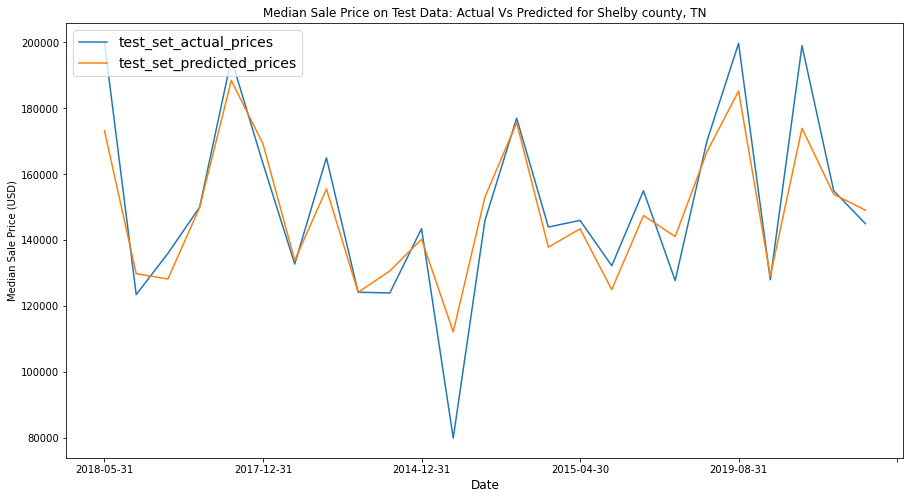

In [89]:
ax3 = ml_df_test_set.plot(figsize = (15,8))

plt.legend(bbox_to_anchor=(0.5,0.5), loc='upper left', ncol=1)

plt.xlabel("Date", fontsize = 12)
plt.ylabel("Median Sale Price (USD)")
plt.title("Median Sale Price on Test Data: Actual Vs Predicted for Shelby county, TN")  

plt.legend(loc=2, fontsize=14)

plt.savefig('./visualizations/LR/test_actual_vs_predicted_prices.jpeg')


In [90]:
# Verify Prediction with 2020 data

X_validation = validation_df.ordinal_date.values.reshape(-1,1)
y_validation_actual_prices =  validation_df.median_sale_price
y_validation_pred_prices = model.predict(X_validation)

ml_validation_df = pd.DataFrame({'date':convert_ordinal_to_date(X_validation),'actual_validation_house_prices': y_validation_actual_prices, 'predicted_validation_house_prices':  y_validation_pred_prices})
ml_validation_df.set_index('date',inplace=True)

print(f"The Actual Vs Predicted House Prices on 2020 data for Shelby")
print(ml_validation_df)


The Actual Vs Predicted House Prices on 2020 data for Shelby
            actual_validation_house_prices  predicted_validation_house_prices
date                                                                         
2020-02-29                        180500.0                      190028.851329
2020-03-31                        207600.0                      190846.405956
2020-04-30                        220000.0                      191637.587853
2020-05-31                        215000.0                      192455.142480
2020-06-30                        220000.0                      193246.324377
2020-07-31                        225500.0                      194063.879004
2020-08-31                        240000.0                      194881.433631
2020-09-30                        245000.0                      195672.615528


In [91]:
print(f"MAE, MSE and RMSE on 2020 Data for Shelby")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_validation_actual_prices, y_validation_pred_prices))
print('Mean Squared Error:', metrics.mean_squared_error(y_validation_actual_prices, y_validation_pred_prices))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_validation_actual_prices, y_validation_pred_prices)))
print('R2 Square', metrics.r2_score(y_test, y_test_pred))

MAE, MSE and RMSE on 2020 Data for Shelby
Mean Absolute Error: 28728.182812305633
Mean Squared Error: 982130462.1220412
Root Mean Squared Error: 31338.960769656056
R2 Square 0.8322598010063076


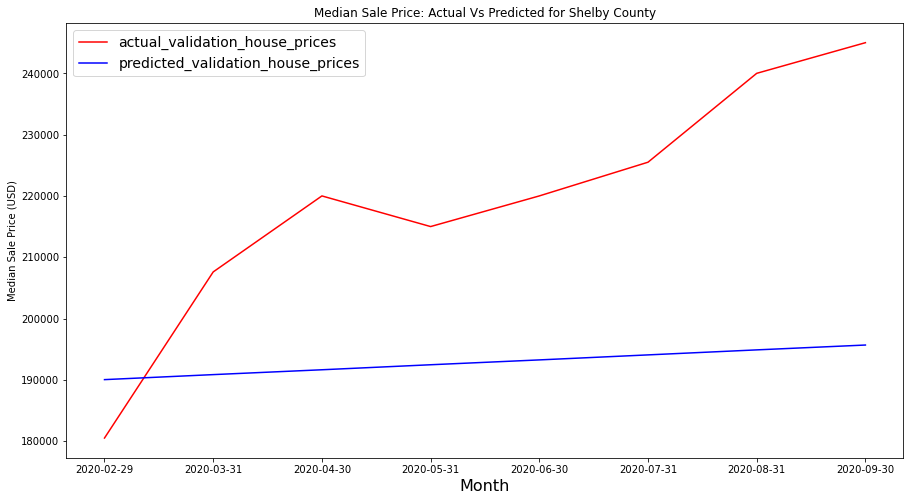

In [93]:
ax4 = ml_validation_df.plot(figsize = (15,8), color = ['red', 'blue'])

plt.legend(bbox_to_anchor=(0.5,0.5), loc='upper right', ncol=1)
plt.xlabel("Month", fontsize = 16)
plt.ylabel("Median Sale Price (USD)")
plt.title(f"Median Sale Price: Actual Vs Predicted for Shelby County")     

plt.legend(loc=2, fontsize=14)
plt.savefig('./visualizations/LR/actual_vs_predicted_house_prices.jpeg')


We can clearly see from our visualization above that there exists a gap between the actual and the predicted housing market trend. This depicts how the housing market was impacted during the covid-19 pandemic.